## K-Means Clustering

### Idea

1. Inputs: 
    - Some array of points `arr` 
    - Number of clusters $k$
2. Pick $k$ random points from `arr`, and set them as your current centroids
3. For every other point in the array, compute the distance from all $k$ centroids
4. Assign points to their nearest centroid based on the argmin of the distance
5. For each centroid group, compute the average position of all points. These become the $k$ new centroids
6. continue, and keep going until some termination condition is met
    - Typically, either until maximum iterations are reached, or until the change in centroid position does not exceed some amount

### Implementation

In [53]:
import numpy as np
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt

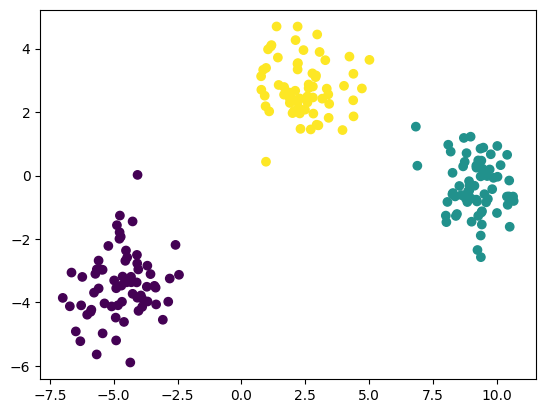

In [54]:
arr,y = make_blobs(n_samples = 200, n_features=2)
plt.scatter(arr[:, 0], arr[:, 1], c=y)

In [59]:
def kmeans_clustering(arr: np.array, k: int, max_iter=500, tol=0.01, plot=True) -> None:
    centroids = arr[np.random.choice(len(arr), k, replace=False)]
    for _ in range(max_iter):
        distance_to_all_centroids = arr[:, np.newaxis, :] - centroids
        # print(distance_to_all_centroids.shape)
        
        squared_distance_to_all_centroids = np.linalg.norm(distance_to_all_centroids, ord=2, axis=2)
        # print(squared_distance_to_all_centroids.shape)

        cluster_labels = np.argmin(squared_distance_to_all_centroids, axis=1)
        # print(cluster_labels.shape)

        new_centroids = np.array([arr[cluster_labels == label].mean(axis=0) if len(arr[cluster_labels == label]) != 0 else centroids[label] for label in range(k)])

        if np.linalg.norm(new_centroids - centroids, ord=2, axis=1).sum() < tol:
            break
        
        centroids = new_centroids

    if plot:
        plt.scatter(arr[:,0],arr[:,1], c=cluster_labels, s=10)
        plt.scatter(centroids[:,0], centroids[:, 1], c='red', s=100)

    return cluster_labels, centroids

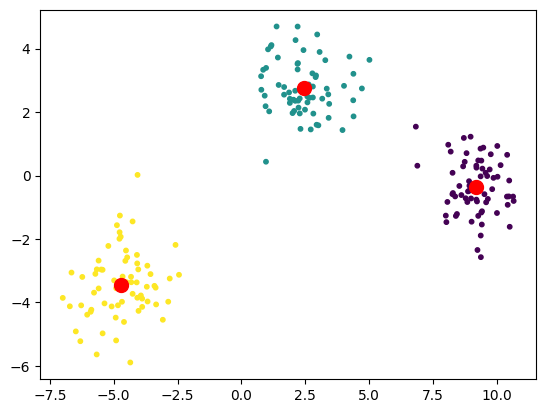

In [60]:
cluster_labels, centroids = kmeans_clustering(arr, 3)

### Evaluating KMeans

- Since KMeans relies on a supplied hyperparameter $k$, getting the right $k$ is quite important

#### WCSS

- Intuitively, in a good cluster, the points in a cluster must generally be more tightly grouped around a centroid compared to a bad cluster
    - This is measured by the **Within Cluster Sum of Squares (WCSS)**, also known as **Inertia**
    $$\begin{aligned}
        \text{WCSS}_{\text{cluster j}} &= \sum_j \sum_{i=0}^{n} (X^{i}_{j} - \text{centroid}_{j})^2
    \end{aligned}$$

    - That is, the WCSS of cluster $j$ is the some of squared distances of all points $X_i$ in cluster $j$ from the centroid of cluster $j$

In [61]:
def compute_wcss(arr: np.array, cluster_labels: np.array, k: int) -> float:
    return np.array([
        np.linalg.norm(arr[cluster_labels == j] - centroids[j], ord=2, axis=1).sum() for j in range(k)
    ]).sum()

compute_wcss(arr, cluster_labels, 3)

np.float64(234.51925706435156)

- As $K$ increases, WCSS always decreases. Intuitively, with more centroids, points will always be closer on average to their centroid

- However, there will come a point where increasing $k$ leads to a marginal decrease in WCSS. This will show up as a "kink" if we plot WCSS against $k$

- This "kink" is where the ideal $k$ should be; that is, we choose $k$ such that increasing it further leads to only a marginal improvement in WCSS

- You can see from the plot below that 3 is the optimal $k$

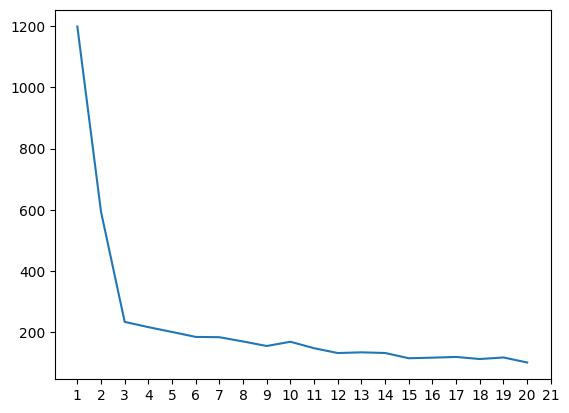

In [74]:
plot = []
for k in range(1,21):
    cluster_labels, centroids = kmeans_clustering(arr, k, plot=False)
    wcss= compute_wcss(arr, cluster_labels, k)
    plot.append((k, wcss))

plt.plot([x[0] for x in plot], [x[1] for x in plot])
plt.xticks(list(range(1,22)));

#### Silhouette Score

- Another way of thinking of cluster assignment quality is to look at how close each point is to points within the same cluster, vs points in the next closest cluster

- Intuitively, if clustering is done well, points should be nearer to all other points in its cluster than in another cluster

In [119]:
k = 3
cluster_labels, centroids = kmeans_clustering(arr, k, plot=False)

In [127]:
def compute_silhouette_score(arr: np.array, centroids: np.array, cluster_labels: np.array):
    all_sil_scores = []
    for i,obs in enumerate(arr):    
        centroid_distances = np.linalg.norm(obs - centroids, axis=1, ord=2)
        nearest_centroid_index, next_nearest_centroid_index = np.argpartition(centroid_distances, 0)[0], np.argpartition(centroid_distances, 0)[1]

        intra_cluster_distance = np.linalg.norm(obs - arr[cluster_labels == nearest_centroid_index], ord=2, axis=1).mean()
        inter_cluster_distance = np.linalg.norm(obs - arr[cluster_labels == next_nearest_centroid_index], ord=2, axis=1).mean()

        sil_score = (inter_cluster_distance - intra_cluster_distance)/(max(inter_cluster_distance, intra_cluster_distance))
        all_sil_scores.append(sil_score)    
    return np.mean(all_sil_scores)

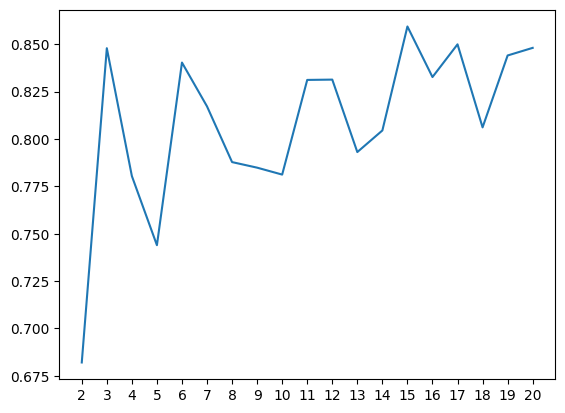

In [140]:
res = []
for k in range(2, 21):
    cluster_labels, centroids = kmeans_clustering(arr, k, plot=False)
    sil_score = compute_silhouette_score(arr, centroids, cluster_labels)
    res.append((k, sil_score))

plt.plot([x[0] for x in res], [x[1] for x in res])
plt.xticks(list(range(2,21)));